## Lab 4: Single and Multivariate Linear Regression

In [ ]:
# optionally install seaborn if not already installed
!python -m pip install seaborn

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Single Variate Linear Regression

This example shows how to compute and plot the optimal solution for single variale linear regression via gradient descent. We will use a subset of the Boston Housing dataset to showcase the model.

*First, we will load the dataset.*

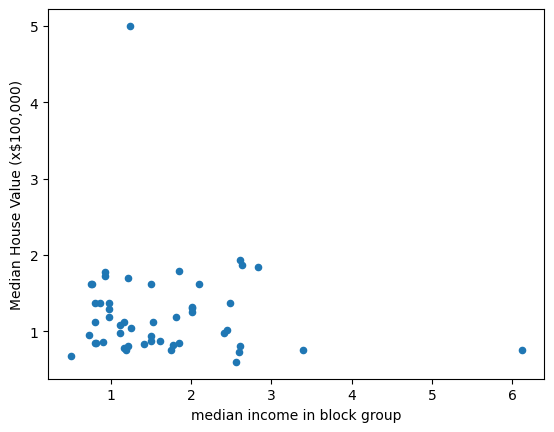

In [2]:
from sklearn.datasets import fetch_california_housing
hd = fetch_california_housing()
housing = pd.DataFrame(hd.data, columns=hd.feature_names)
housing['target'] = hd.target
housing.iloc[50:100,:].plot.scatter(x='MedInc', y='target')
plt.xlabel('median income in block group')
plt.ylabel('Median House Value (x$100,000)')
plt.show()
# housing

In [3]:
print(hd.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [4]:
housing.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


To make things easier to visualize, we're only going to pick 50 samples from the dataset. Also, to ensure proper model training, we will normalize the features (not including the target) using L-inf (max) normalization.

In [5]:
# extract 50 rows
data = housing.loc[51:100].to_numpy()
# normalize the data except for the target
data[:, :-1] = data[:, :-1] / data[:, :-1].max(axis=0)


For the first examples, we're going to pick one of the variables, `MedInc`, and predict the response, `target`, from its values. 

In [6]:
x = data[:,0]
y = data[:,-1]
x, y, x.shape

(array([0.24590164, 0.1815537 , 0.20389651, 0.2631123 , 0.23066865,
        0.24609777, 0.13356651, 0.19892781, 0.41882549, 0.55454947,
        1.        , 0.14727947, 0.19466192, 0.42394129, 0.19069022,
        0.13167056, 0.42649102, 0.30263308, 0.1602079 , 0.28960659,
        0.11908537, 0.28602716, 0.0817057 , 0.40583169, 0.15103869,
        0.39984963, 0.18160273, 0.13118023, 0.32875145, 0.24516614,
        0.19069022, 0.24856578, 0.13198111, 0.29563768, 0.39362241,
        0.15968488, 0.12421751, 0.15890035, 0.20322639, 0.34221924,
        0.14167334, 0.12258307, 0.43074057, 0.30199565, 0.32845725,
        0.46328228, 0.32790154, 0.19915663, 0.42665446, 0.40717193]),
 array([0.938  , 0.975  , 1.042  , 0.875  , 0.831  , 0.875  , 0.853  ,
        0.803  , 0.6    , 0.757  , 0.75   , 0.861  , 0.761  , 0.735  ,
        0.784  , 0.844  , 0.813  , 0.85   , 1.292  , 0.825  , 0.952  ,
        0.75   , 0.675  , 1.375  , 1.775  , 1.021  , 1.083  , 1.125  ,
        1.313  , 1.625  , 1.125  ,

Next, we will find the best model via Gradient Descent.

In [7]:
def gradient(t, X, y):
    """Compute the current error and gradient."""
    # Hypothesis/estimate values for y
    y_estimate = X.dot(t).flatten()
    # Loss - the difference between the estimated and actual values of y
    loss = y_estimate - y.flatten()
    # Compute gradient
    grad = (1.0 / X.shape[0]) * X.T.dot(loss)
    # Cost function value
    cost = float(0.5 * np.mean((y_estimate - y.flatten())**2))
    return grad.reshape(t.shape), cost

def compute_cost(t, X, y):
    """Compute the current error/cost."""
    y_estimate = X.dot(t).flatten()
    return float(0.5 * np.mean((y_estimate - y.flatten())**2))

def gradient_descent(x, y, alpha=0.5, tolerance=1e-5, maxit=1e+6, nulbias=False):
    """Finds the best line fit for predicting y given x.
       Keep track of and also return tested models, gradients, and errors 
       along the optimization path.
    """
    if x.ndim == 1:
        x = x.reshape(-1, 1)
    # add intercept term to x -- acounts for the bias
    X = np.hstack((np.ones((x.shape[0], 1)), x))
    # start with a random (or zeros) theta vector
    t = np.random.randn(X.shape[1], 1)
    if nulbias:
        t[0] = 0
    # perform gradient descent
    it = 0
    models = []
    grads = []
    errors = []
    while it < maxit:
        grad, error = gradient(t, X, y)
        models.append(t)
        grads.append(grad)
        errors.append(error)
        new_t = t - alpha * grad
        if nulbias:
            new_t[0] = 0
        # check whether we should stop
        if np.sum(abs(new_t - t)) < tolerance:
            break
        # update theta
        t = new_t
        it += 1
    if it == maxit:
        print("Warning: reached maximum number of iterations without convergence.")
    return X, t, models, grads, errors

def plotmodel(x, y, t, start_at_zero=False):
    """Plot the line of a given model."""
    if t is not None:
        if start_at_zero:
            x = np.append([0], x)
            y = np.append([0], y)
        plt.plot(x, t[0] + x/x.max() * t[1], c='g', label='Model')
    plt.scatter(x, y, c='b', label='Data')
    plt.legend(loc='best')
    plt.xlabel('MedInc')
    plt.ylabel('Median House Price (x$100,000)')
    if start_at_zero:
        plt.ylim(ymin=0)
        plt.xlim(xmin=0)
    plt.show()

Let's see what our data looks like by plotting the response ($y$) in terms of the predictor ($x$). We can choose any line in the plane to be a model for predicting the response.

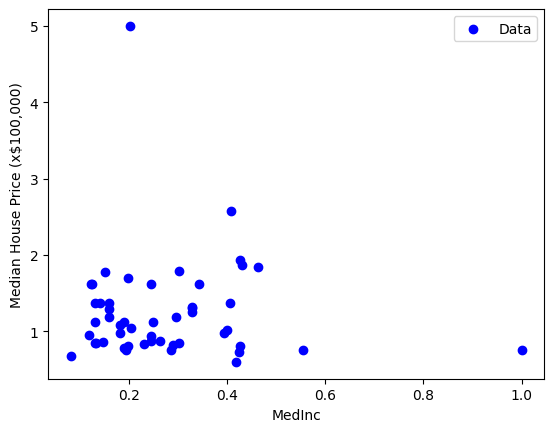

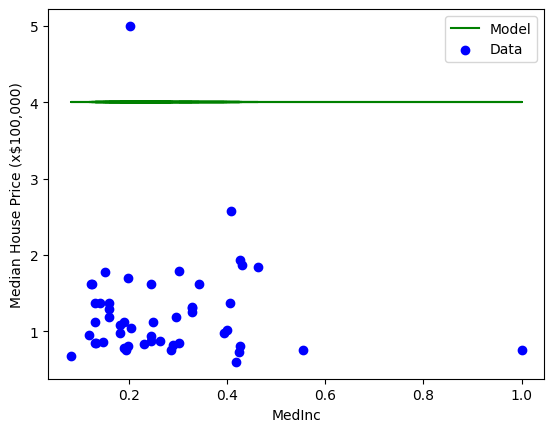

In [8]:
plotmodel(x, y, None)
plotmodel(x, y, np.array([4, 0]))

Initially, let's assume that we don't actually have a bias term. This will make visualizing the parameter space easier. We'll find the best model and plot a few models along the way, specifically, the initial random model and models after traversing each quarter of the search space.

# iterations:  190
first model:  [[0.        ]
 [0.74377145]]
best model:  [[0.        ]
 [3.43439388]]
Iteration:  1
Gradient:  [[-1.0492102 ]
 [-0.26449006]]
Error:  0.7888205130267848


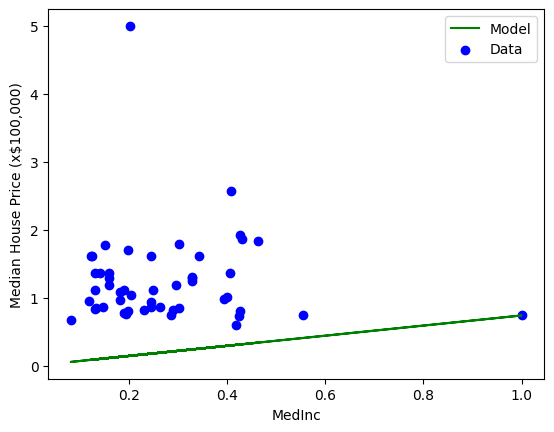

Iteration:  48
Gradient:  [[-0.38226761]
 [-0.02475959]]
Error:  0.4360914795220706


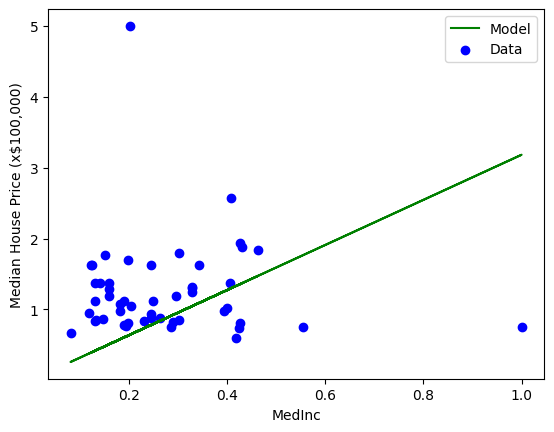

Iteration:  96
Gradient:  [[-0.31951651]
 [-0.0022039 ]]
Error:  0.43299778593270305


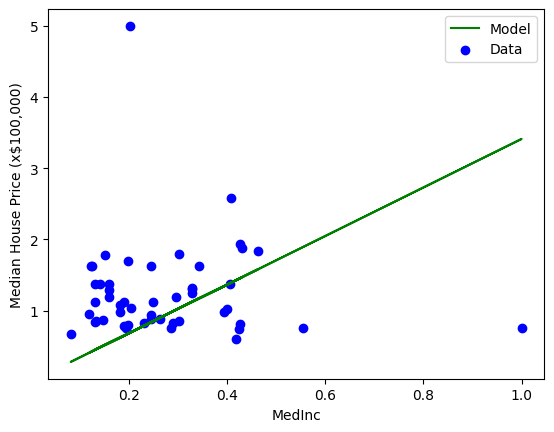

Iteration:  142
Gradient:  [[-3.13988793e-01]
 [-2.16975922e-04]]
Error:  0.4329733180112565


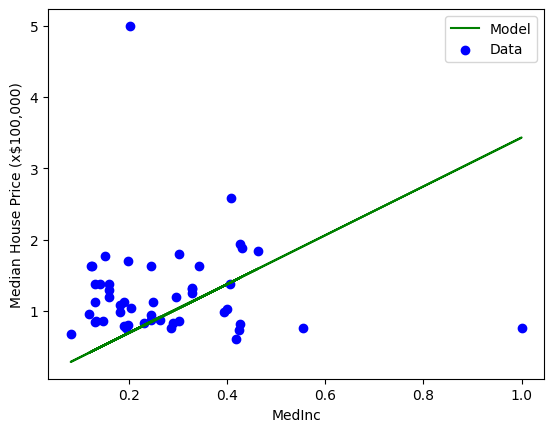

Iteration:  190
Gradient:  [[-3.13438886e-01]
 [-1.93134159e-05]]
Error:  0.4329730804292539


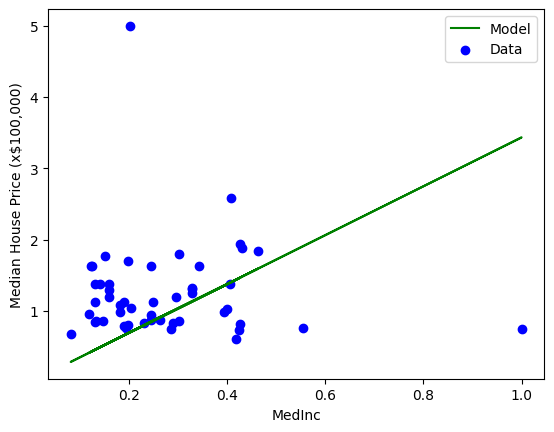

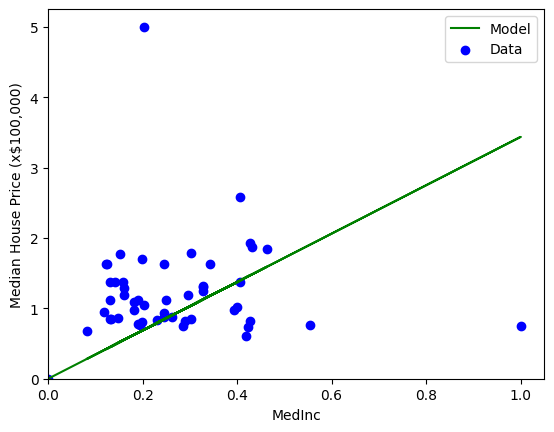

In [9]:
X, t, models, grads, errors = gradient_descent(x, y, nulbias=True)
print("# iterations: ", len(models))
print("first model: ", models[0])
print("best model: ", t)

nits = len(models)
ts = [0, nits//4, nits//2, 3*(nits//4), nits-1] # quartles
for i in ts:
    print("Iteration: ", i+1)
    print("Gradient: ", grads[i])
    print("Error: ", errors[i])
    plotmodel(x, y, models[i])
plotmodel(x, y, models[-1], True)

We can plot the cost function in terms of the $\theta$ value. Note that, as $\theta$ gets closer to the optimum value, the distance traveled decreases, even through the step size $\alpha$ remains constant. After 10 steps, the cost function was only 0.34 away from its optimum value.

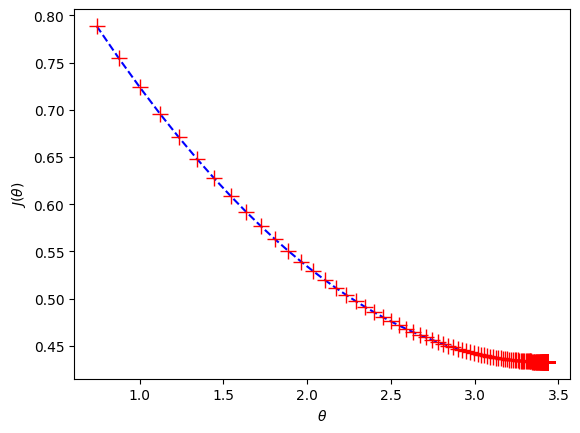

In [10]:
plt.plot([m[1] for m in models], errors, 'b+--', markersize=12, markeredgecolor='r')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$J(\theta)$')
plt.show()

If we also consider the bias term, the optimization takes slightly longer, but is able to fit the evidence much better.

# iterations:  585
first model:  [[ 0.84556291]
 [-0.80665956]]
best model:  [[ 1.31019117]
 [-0.21058702]]
Iteration:  1
Gradient:  [[-0.62762453]
 [-0.18566173]]
Error:  0.42885053955852015


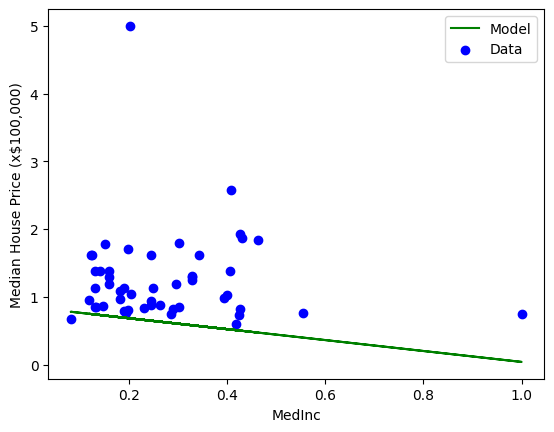

Iteration:  147
Gradient:  [[ 0.00053217]
 [-0.00190357]]
Error:  0.22779636569691492


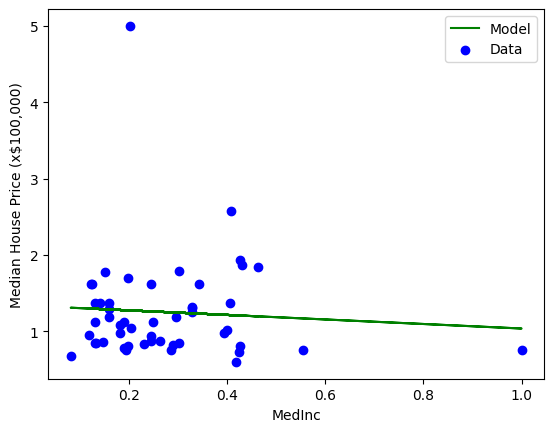

Iteration:  293
Gradient:  [[ 0.00010708]
 [-0.00038301]]
Error:  0.22771056294643066


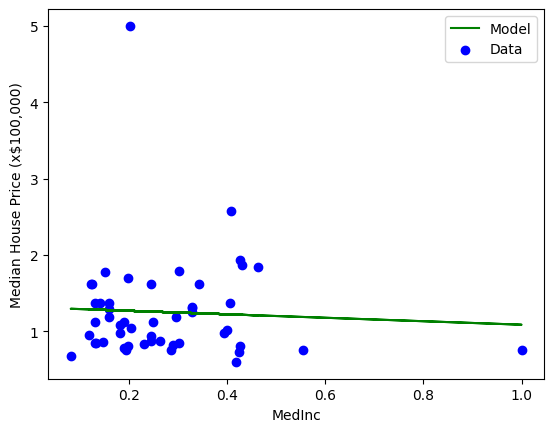

Iteration:  439
Gradient:  [[ 2.15447459e-05]
 [-7.70653599e-05]]
Error:  0.2277070892553235


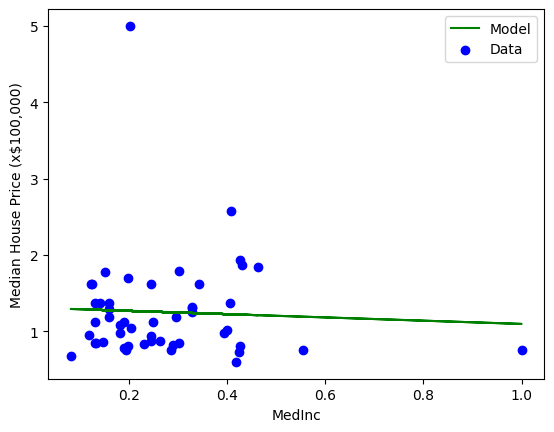

Iteration:  585
Gradient:  [[ 4.33497273e-06]
 [-1.55061580e-05]]
Error:  0.22770694862428498


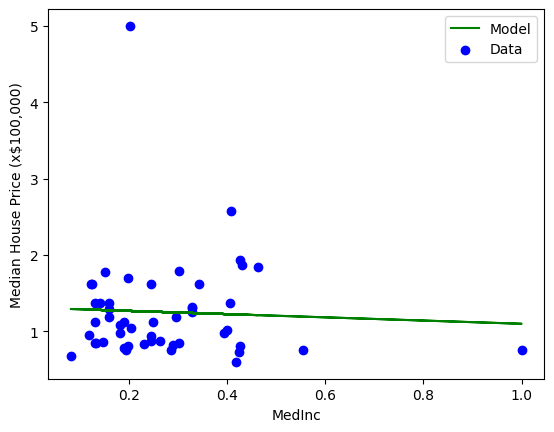

In [11]:
X, t, models, grads, errors = gradient_descent(x, y)
print("# iterations: ", len(models))
print("first model: ", models[0])
print("best model: ", t)

nits = len(models)
ts = [0, nits//4, nits//2, 3*(nits//4), nits-1] # quartles
for i in ts:
    print("Iteration: ", i+1)
    print("Gradient: ", grads[i])
    print("Error: ", errors[i])
    plotmodel(x, y, models[i])

Since $\theta$ is now a vector with two features, we will plot the cost function in 3D space in terms of the two possible values for $\theta$ and the cost function response $J(\theta)$.

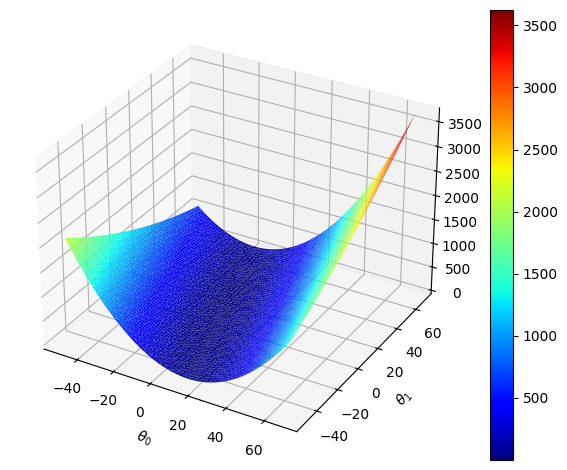

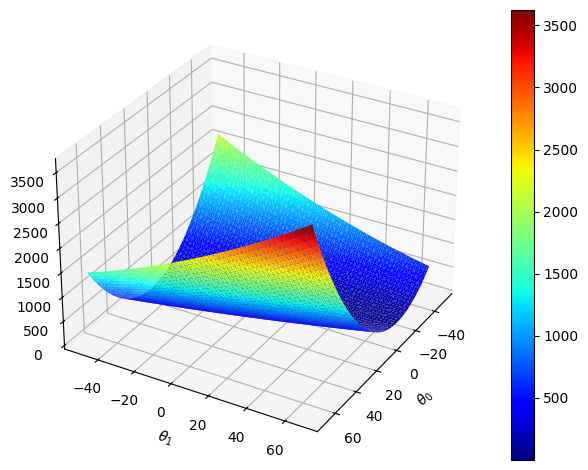

In [12]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

def plotcost(X, y, start=-100, end=100, step=2, rotate=False):
    """Construct a 3D plot of the cost function range."""
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    t0s = []
    t1s = []
    errors = []
    for t0 in np.arange(start, end, step):
        for t1 in np.arange(start, end, step):
            t0s.append(t0)
            t1s.append(t1)
            errors.append(compute_cost(np.array([t0, t1]), X, y))
    
    surf = ax.plot_trisurf(t0s, t1s, errors, cmap=cm.jet, linewidth=0.2)
    fig.colorbar(surf)
    plt.xlabel(r'$\theta_0$')
    plt.ylabel(r'$\theta_1$')

    if rotate:
        ax.view_init(30, 30)

    fig.tight_layout()
    plt.show()
    
plotcost(X, y, start=-50, end=70)
plotcost(X, y, start=-50, end=70, rotate=True)

In [ ]:
# Compare our solution to scikit-learn's
from sklearn.linear_model import LinearRegression
reg = LinearRegression(fit_intercept=False)

# Generate synthetic data
np.random.seed(42)
n_samples = data.shape[0]
X = np.random.rand(n_samples, 2)
true_coef = np.array([2.0, -3.5])
y = X @ true_coef + np.random.randn(n_samples) * 0.9

# scikit-learn reference model
model_sk = LinearRegression(fit_intercept=False)
model_sk.fit(X, y)

# Gradient descent model
X2, t, models, grads, errors = gradient_descent(X, y, nulbias=True, alpha=0.01, maxit=100000)

print("Sklearn Coefficients:", model_sk.coef_)
print("GD Coefficients:", t[1:])
print("Sklearn Intercept:", model_sk.intercept_)
print("GD Intercept:", t[0])
print("Sklearn Error:", float(0.5 * np.mean((model_sk.predict(X) - y.flatten())**2)))
print("GD Error:", float(0.5 * np.mean(((X2 @ t).flatten() - y.flatten())**2)))


Sklearn Coefficients: [ 2.44991022 -3.94268554]
GD Coefficients: [[ 2.44429028]
 [-3.93769875]]
Sklearn Intercept: 0.0
GD Intercept: [0.]
Sklearn Error: 0.333940280403062
GD Error: 0.3339429410130637


## Task: Multi-Variate Linear Regression

Modify the gradient function given to you earlier to perform multivariate linear regression, i.e., the input contains more than one variable. Then, use the function you created to find the combination of any two dependent variables with the least root mean square error with regards to the response/target variable. You do not need to plot the cost function for this exercise.

In [ ]:
# get column names
Index = housing.columns[:-1]

# extract 50 rows
data = housing.loc[51:100].to_numpy()
# normalize the data except for the target
data[:, :-1] = data[:, :-1] / data[:, :-1].max(axis=0)

# get the target
y = data[:,-1].reshape(-1, 1)
results = []
for i in range(len(housing.columns)-1):
  x1 = data[:,i]
  for j in range(i+1, len(housing.columns)-1):
    x2 = data[:,j]
    ...
# get results with the lowest error
results = sorted(results, key=lambda x: x[2])
print("Best pair of features: ", results[0])

Repeat the same exercise using sklearn's linear regression model.

Compare the results and discuss your findings.